In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
set_seed(0)

# Definition of the scalar network
### (plotting code reused from Prof. Vinitksy at NYU)


$$f[x;\phi] = \beta_3 + \omega_3 \cdot \cos \left[\beta_2 + \omega_2 \cdot \exp \left[\beta_1 + \omega_1 \cdot \sin \left[\beta_0 + \omega_0 \cdot x \right] \right] \right]$$

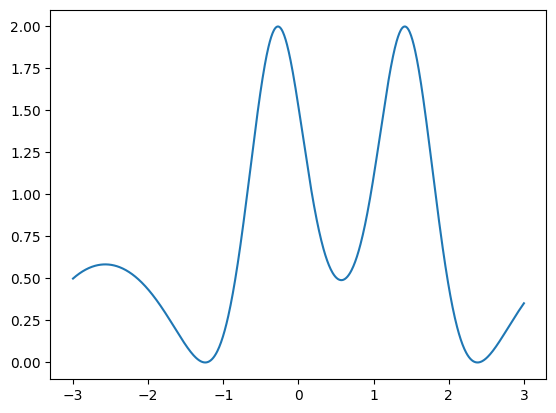

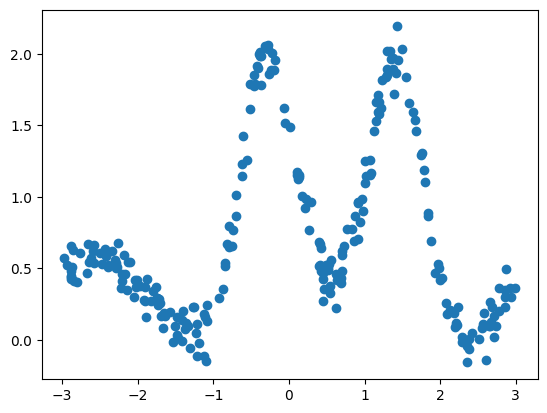

In [2]:
omega_0 = 1.0
beta_0 = 1.0
omega_1 = 1.0
beta_1 = 1.0
omega_2 = 1.0
beta_2 = 1.0
omega_3 = 1.0
beta_3 = 1.0
# $$f[x;\phi] = \beta_3 + \omega_3 \cdot \cos \left[\beta_2 + \omega_2 \cdot \exp \left[\beta_1 + \omega_1 \cdot \sin \left[\beta_0 + \omega_0 \cdot x] \right] \right] \right]$$
def f(x, omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3):
    return beta_3 + omega_3 * np.cos(beta_2 + omega_2 * np.exp(beta_1 + omega_1 * np.sin(beta_0 + omega_0 * x)))

x_range = np.linspace(-3, 3, 1000)
plt.figure()
plt.plot(x_range, f(x_range, omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3))

# Lets generate a dataset for this and try to fit it with this function
# Lets just make it some random polynomial
data_size = 256
x_data = np.random.uniform(-3, 3, data_size)
y_data = f(x_data, omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3) + np.random.normal(0, 0.1, data_size)
# plot it real quick
plt.figure()
plt.scatter(x_data, y_data)

### Now implementing backpropagtion 

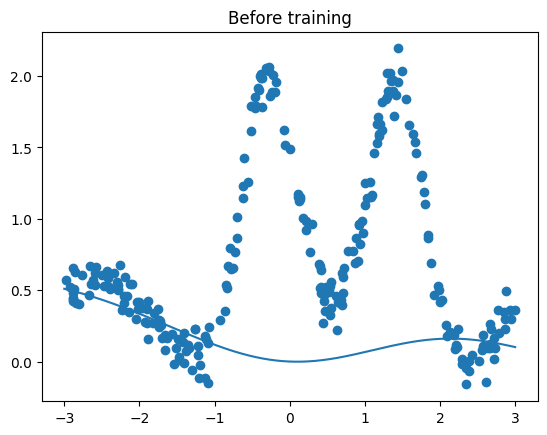

Loss at iteration 0: 0.7040600395792963
Loss at iteration 100: 0.26699801948321134
Loss at iteration 200: 0.25978441323425616
Loss at iteration 300: 0.2576184970575487
Loss at iteration 400: 0.2557656504995557
Loss at iteration 500: 0.25384765018590305
Loss at iteration 600: 0.251463221947695
Loss at iteration 700: 0.24675907796145494
Loss at iteration 800: 0.0393673921387528
Loss at iteration 900: 0.010366379343821707


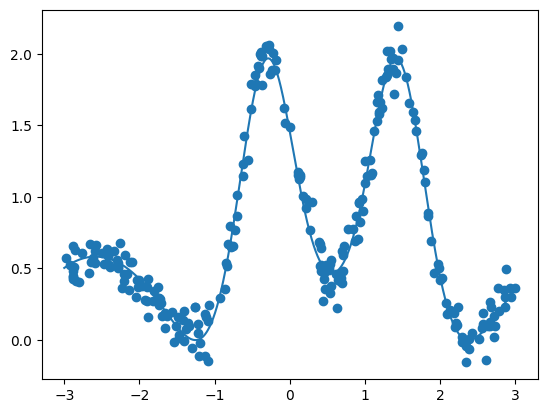

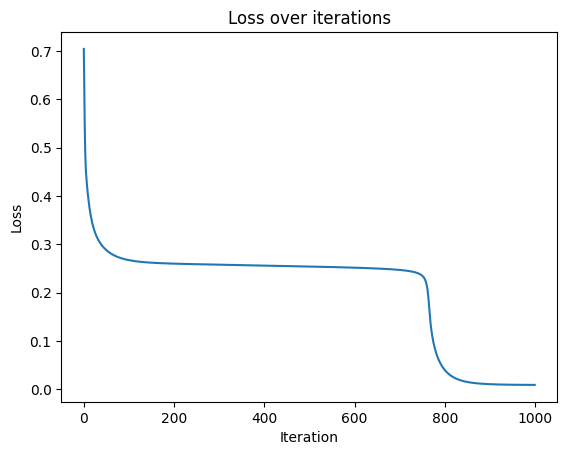

In [3]:
class ScalarFunction():
    def __init__(self, omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3, learning_rate):
        self.omega_0 = omega_0
        self.beta_0 = beta_0
        self.omega_1 = omega_1
        self.beta_1 = beta_1
        self.omega_2 = omega_2
        self.beta_2 = beta_2
        self.omega_3 = omega_3
        self.beta_3 = beta_3
        self.learning_rate = learning_rate

    # Now lets implement backpropagation
    def compute_gradients(self, x_data, y_data):
        '''Computes and returns an ordered list of the gradients of the loss with respect to each parameter'''
        # this function should return the gradient values of omega_0, beta_0, etc.
        # Forward pass
        y_predicted = self.forward(x_data)
        
        # Backward pass
        
        sin_on_f0 = np.sin(self.beta_0 + self.omega_0 * x_data)
        exp_on_f1 = np.exp(self.beta_1 + self.omega_1 * sin_on_f0)
        cos_on_f2 = np.cos(self.beta_2 + self.omega_2 * exp_on_f1)
        
        # Gradients
        dL_dy = 2 * (y_predicted - y_data)  # Derivative of MSE loss
        
        dL_domega_3 = np.mean(dL_dy * cos_on_f2)
        dL_dbeta_3 = np.mean(dL_dy)
        
        dL_domega_2 = np.mean(dL_dy * self.omega_3 * (-np.sin(self.beta_2 + self.omega_2 * exp_on_f1)) * exp_on_f1)
        dL_dbeta_2 = np.mean(dL_dy * self.omega_3 * (-np.sin(self.beta_2 + self.omega_2 * exp_on_f1)))
        
        dL_domega_1 = np.mean(dL_dy * self.omega_3 * (-np.sin(self.beta_2 + self.omega_2 * exp_on_f1)) * self.omega_2 * exp_on_f1 * sin_on_f0)
        dL_dbeta_1 = np.mean(dL_dy * self.omega_3 * (-np.sin(self.beta_2 + self.omega_2 * exp_on_f1)) * self.omega_2 * exp_on_f1)
        
        dL_domega_0 = np.mean(dL_dy * self.omega_3 * (-np.sin(self.beta_2 + self.omega_2 * exp_on_f1)) * self.omega_2 * exp_on_f1 * self.omega_1 * np.cos(self.beta_0 + self.omega_0 * x_data) * x_data)
    
        dL_dbeta_0 = np.mean(dL_dy * self.omega_3 * (-np.sin(self.beta_2 + self.omega_2 * exp_on_f1)) * self.omega_2 * exp_on_f1 * self.omega_1 * np.cos(self.beta_0 + self.omega_0 * x_data))
    
        return dL_domega_0, dL_dbeta_0, dL_domega_1, dL_dbeta_1, dL_domega_2, dL_dbeta_2, dL_domega_3, dL_dbeta_3

        
    
        
    def apply_gradients(self, dL_domega_0, dL_dbeta_0, dL_domega_1, dL_dbeta_1, dL_domega_2, dL_dbeta_2, dL_domega_3, dL_dbeta_3, learning_rate):
        '''Apply the computed gradients using SGD'''
        self.omega_0 -= learning_rate*np.mean(dL_domega_0)
        self.omega_1 -= learning_rate*np.mean(dL_domega_1)
        self.omega_2 -= learning_rate*np.mean(dL_domega_2)
        self.omega_3 -= learning_rate*np.mean(dL_domega_3)
        self.beta_0 -= learning_rate*np.mean(dL_dbeta_0)
        self.beta_1 -= learning_rate*np.mean(dL_dbeta_1)
        self.beta_2 -= learning_rate*np.mean(dL_dbeta_2)
        self.beta_3 -= learning_rate*np.mean(dL_dbeta_3)

    def update(self, x_data, y_data):
        dL_domega_0, dL_dbeta_0, dL_domega_1, dL_dbeta_1, dL_domega_2, dL_dbeta_2, dL_domega_3, dL_dbeta_3 = self.compute_gradients(x_data, y_data)
        self.apply_gradients(dL_domega_0, dL_dbeta_0, dL_domega_1, dL_dbeta_1, dL_domega_2, dL_dbeta_2, dL_domega_3, dL_dbeta_3, learning_rate)
      

    def forward(self, x_data):
        '''return the predictions'''
        return f(x_data, self.omega_0, self.beta_0, self.omega_1, self.beta_1, self.omega_2, self.beta_2, self.omega_3, self.beta_3) 
        # TODO
    
    def loss(self, x_data, y_true):
        '''return the mean loss'''
        YP = self.forward(x_data)
        return np.mean((YP- y_true)**2)
        # TODO

# Now lets train the model
omega_0 = 0.5
beta_0 = 0.5
omega_1 = 0.5
beta_1 = 0.5
omega_2 = 1.0
beta_2 = 1.0
omega_3 = 1.0
beta_3 = 1.0
learning_rate = 0.03

func = ScalarFunction(omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3, learning_rate)

def plot_and_run(func, num_iters, selection_fn):
    # lets quickly plot what this looks like before it all gets started
    y_pred = func.forward(x_range)
    plt.figure()
    plt.plot(x_range, y_pred)
    plt.scatter(x_data, y_data)
    plt.title('Before training')
    plt.show()

    # Okay now lets run gradient descent and periodically store the loss for plotting later
    losses = []
    for i in range(num_iters):
        func.update(*selection_fn(x_data, y_data))
        #losses.append(func.update(*selection_fn(x_data, y_data)))
        losses.append(func.loss(x_data, y_data))
        if i % 100 == 0:
            print(f'Loss at iteration {i}: {losses[-1]}')

    # plot the predictions at the end of training
    y_pred = func.forward(x_range)
    plt.figure()
    plt.plot(x_range, y_pred)
    plt.scatter(x_data, y_data)

    # plot the loss functions
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss over iterations')

def selection_fn(x_data, y_data):
    # This function is used to select the data points to use for training
    return x_data, y_data

plot_and_run(func, 1000, selection_fn)

## Implementing a deep network 

### Using a module class which has methods such as __call__ , backward etc 

Loss at iteration 0: 1.1688700155919982
Loss at iteration 100: 0.0008870537000003648
Loss at iteration 200: 0.0005086459658891258
Loss at iteration 300: 0.0004183301439274573
Loss at iteration 400: 0.0003801475821150172
Loss at iteration 500: 0.0003547812544896157
Loss at iteration 600: 0.0003354549894738516
Loss at iteration 700: 0.0003200312027276058
Loss at iteration 800: 0.00030722572094705927
Loss at iteration 900: 0.000296301323971062
Loss at iteration 1000: 0.0002869907566716472
Loss at iteration 1100: 0.00027868779772615695
Loss at iteration 1200: 0.00027128747242052733
Loss at iteration 1300: 0.0002645943248253547
Loss at iteration 1400: 0.0002584160039080754
Loss at iteration 1500: 0.00025271520451115295
Loss at iteration 1600: 0.0002473208940359054
Loss at iteration 1700: 0.0002426182298667773
Loss at iteration 1800: 0.00023827042777175853
Loss at iteration 1900: 0.00023416179046435994
Loss at iteration 2000: 0.00023068230181811503
Loss at iteration 2100: 0.00022752178092457

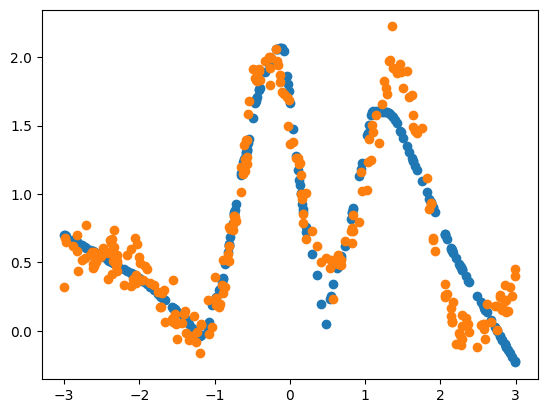

In [4]:

class MeanSquaredLoss():
    def __init__(self):
        self.loss_val = 0

    def __call__(self, y_pred, y_true):
        
        return np.mean((y_pred - y_true)**2)/len(y_true)
    
    def grad(self, y_pred, y_true):
        
        return 2*(y_pred - y_true)/len(y_true)
    
    
class ReLU():
    def __call__(self, x):
        
        self.x = x
        return np.maximum(0,x)
        #output = (0 if self.input < 0 else self.input)
        #return output
    
    def backward(self, grad):
        # TODO implement this
        
        return grad*(self.x > 0)

    def zero_grad(self):
        pass

    def parameters(self):
        return []  # ReLu has no parameters

class Layer():
    def __init__(self, in_features, out_features):
        '''Initializer for the layer'''
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.random.normal(0,1,(in_features,out_features))
        self.bias = np.random.normal(0,1,out_features)
        #self.weight = np.full((in_features, out_features), 0.2)  # All weights = 0.5
        #self.bias = np.full(out_features, 0.2)
        self.weight_grad = np.zeros((in_features,out_features))
        self.bias_grad = np.zeros(out_features)
        
    def parameters(self):
        '''Return the current parameters and their gradients'''
        return [(self.weight, self.weight_grad), (self.bias, self.bias_grad)]
    
    def __call__(self, x):
        '''Compute the forward pass and store the input for the backward pass'''
        
        self.x = x
        return np.dot(x,self.weight) + self.bias

    def backward(self, grad):
        '''Compute the gradients and store them in a weight_grad and bias_grad variables. Return the gradients that will be needed for the next layer in the backward pass'''
        
        self.weight_grad +=  np.dot(self.x.T,grad)
        self.bias_grad += np.sum(grad, axis=0)
        return np.dot(grad, self.weight.T) # backpropagating through layers 
    
    def zero_grad(self):
        '''Set the gradients to zero'''
        
        self.weight_grad = np.zeros_like(self.weight)
        self.bias_grad = np.zeros_like(self.bias)
        
class Network():
    def __init__(self, layers):
        self.layers = layers
        
            
            
    def parameters(self):
        '''Returns a list of list of all the parameters in the network'''
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
            
        return params
       
 
    def __call__(self, x):
        '''Returns the final output of the network'''
        for layer in self.layers:
            x  = layer(x)
        return x
    
    def backward(self, grad):
        '''Goes backwards through the net and calls the backward function of each layer'''
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        
    def zero_grad(self):
        '''Goes backward through the net and calls the zero_grad function of each layer'''
        for layer in self.layers:
            layer.zero_grad()



class SGDOptimizer():
    def __init__(self, network, loss_fn, learning_rate):
        self.network = network
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        
    def step(self, x_data, y_data):
        '''Update the parameters of the network and return the loss'''
        
        self.network.zero_grad()
        y_pred = self.network(x_data)
        loss = self.loss_fn(y_pred, y_data)
        grad = self.loss_fn.grad(y_pred, y_data)
        self.network.backward(grad)
        for params, grad in self.network.parameters():
            params -= self.learning_rate * grad
        return loss

        
# Now lets try this over the dataset we build before
omega_0 = 1.0
beta_0 = 1.0
omega_1 = 1.0
beta_1 = 1.0
omega_2 = 1.0
beta_2 = 1.0
omega_3 = 1.0
beta_3 = 1.0
data_size = 256
x_data = np.random.uniform(-3, 3, (data_size, 1))
y_data = f(x_data, omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3) + np.random.normal(0, 0.1, (data_size, 1))

# instantiate a network
layer1 = Layer(1, 32)
layer2 = Layer(32, 32)
layer3 = Layer(32, 1)
relu_1 = ReLU()
relu_2 = ReLU()
network = Network([layer1, relu_1, layer2, relu_2, layer3])
loss_fn = MeanSquaredLoss()
optimizer = SGDOptimizer(network, loss_fn, 0.001)

# Now lets train the network
losses = []
for i in range(3000):
    loss = optimizer.step(x_data, y_data)
    losses.append(loss)
    if i % 100 == 0:
        print(f'Loss at iteration {i}: {loss}')
        
# Now lets output a prediction
y_pred = network(x_data)
plt.figure()
plt.scatter(x_data, y_pred)
plt.scatter(x_data, y_data)

### Changing the activation to a LeakyRelU https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html

Loss at iteration 0: 0.07505873103241592
Loss at iteration 100: 0.0015105220400376458
Loss at iteration 200: 0.0009014990697756417
Loss at iteration 300: 0.0006600421737133074
Loss at iteration 400: 0.0005267770153541479
Loss at iteration 500: 0.00045049545979796964
Loss at iteration 600: 0.00040235779048475263
Loss at iteration 700: 0.00036973124757701573
Loss at iteration 800: 0.0003466780210234029
Loss at iteration 900: 0.0003296654533759849
Loss at iteration 1000: 0.00031701228648641606
Loss at iteration 1100: 0.00030742463662626856
Loss at iteration 1200: 0.00030026114861413913
Loss at iteration 1300: 0.0002947300872899101
Loss at iteration 1400: 0.00029040743696459885
Loss at iteration 1500: 0.000286897478696385
Loss at iteration 1600: 0.00028404861370628063
Loss at iteration 1700: 0.0002818056976819159
Loss at iteration 1800: 0.00027999228419950276
Loss at iteration 1900: 0.00027853212137453104
Loss at iteration 2000: 0.00027738133201833247
Loss at iteration 2100: 0.000276308569

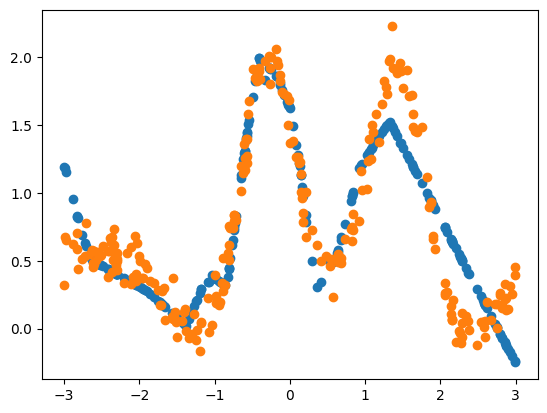

In [5]:
# TODO: Implement the leaky relu, train a model with it, and plot the results below
class LeakyReLU():
    def __init__(self, alpha):
        self.alpha = alpha
    def __call__(self, x):
        # TODO
        self.x = x
        return np.maximum(self.alpha*x,x)
    def backward(self, grad):
        # TODO
        return grad*(self.x > 0) + self.alpha * grad * (self.alpha <=0)
    def zero_grad(self):
        pass
    def parameters(self):
        return []

# Now lets try this with the leaky relu
layer1 = Layer(1, 32)
layer2 = Layer(32, 32)
layer3 = Layer(32, 1)
leaky_relu = LeakyReLU(0.01)
network = Network([layer1, leaky_relu, layer2, leaky_relu, layer3])
loss_fn = MeanSquaredLoss()
optimizer = SGDOptimizer(network, loss_fn, 0.001)

# Now lets train the network
losses = []
for i in range(3000):
    loss = optimizer.step(x_data, y_data)
    losses.append(loss)
    if i % 100 == 0:
        print(f'Loss at iteration {i}: {loss}')
        
# Now lets output a prediction
y_pred = network(x_data)
plt.figure()
plt.scatter(x_data, y_pred)
plt.scatter(x_data, y_data)

    

### Implementing the Adam and Momentum optimizer

Loss at iteration 0: 2.769437314233147
Loss at iteration 1000: 0.00026456174120959784
Loss at iteration 2000: 0.00013925397274756716
Loss at iteration 0: 1.0590532148684373
Loss at iteration 1000: 0.00034579878897558064
Loss at iteration 2000: 0.00015766999084915244
Loss at iteration 0: 0.5601251013098305
Loss at iteration 1000: 0.00011092547835115944
Loss at iteration 2000: 6.328602272646487e-05


Text(0.5, 1.0, 'Loss over iterations')

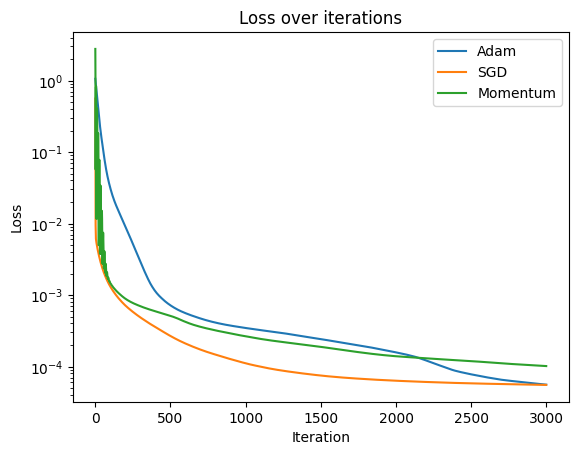

In [8]:
# TODO: Implement the Adam optimizer, implement the momentum optimizer
# and compare the results below with an SGD optimizer. You should
# track the losses for each along the way in variables called losses_adam, losses_sgd, losses_momentum.

class MomentumOptimizer:
    def __init__(self, network, loss_fn, learning_rate = 0.001,beta=0.9):
        self.network = network
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        self.momentum = beta
        self.velocities = [np.zeros_like(param) for param, grad in self.network.parameters()]
    

    def step(self,x_data, y_data):
        self.network.zero_grad()
        y_pred = self.network(x_data)
        loss = self.loss_fn(y_pred, y_data)
        grad = self.loss_fn.grad(y_pred, y_data)
        self.network.backward(grad)

        for i, (param, grad) in enumerate(self.network.parameters()):
            self.velocities[i] = self.momentum*self.velocities[i] + (1 - self.momentum)*(grad)

            param -= self.learning_rate*self.velocities[i]

        return loss


            

class Adam:
    def __init__(self, network, loss_fn, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.network = network
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
       
        self.t = 0     
   
        
        self.m = [np.zeros_like(param) for param, grad in self.network.parameters()]
        self.v = [np.zeros_like(param) for param, grad in self.network.parameters()]
        
    def update(self, x_data, y_data):
        self.network.zero_grad()
        y_pred = self.network(x_data)
        loss = self.loss_fn(y_pred, y_data)
        grad = self.loss_fn.grad(y_pred, y_data)
        self.network.backward(grad)
            
        self.t += 1
        for i, (param, grad) in enumerate(self.network.parameters()):
            self.m[i] = (1- self.beta1) *grad + self.beta1*self.m[i]
            
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            mh = self.m[i]/(1-self.beta1**self.t)
            vh = self.v[i]/(1- self.beta2**self.t)
            param -= self.learning_rate*mh/ (np.sqrt(vh) + self.epsilon)
        
        return loss

layer1 = Layer(1, 32)
layer2 = Layer(32, 32)
layer3 = Layer(32, 1)
relu_1 = ReLU()
relu_2 = ReLU()
network = Network([layer1, relu_1, layer2, relu_2, layer3])
loss_fn = MeanSquaredLoss()
optimizer = MomentumOptimizer(network, loss_fn, 0.001)

# Now lets train the network
losses_momentum = []
for i in range(3000):
    loss = optimizer.step(x_data, y_data)
    losses_momentum.append(loss.item())
    if i % 1000 == 0:
        print(f'Loss at iteration {i}: {loss}')


layer1 = Layer(1, 32)
layer2 = Layer(32, 32)
layer3 = Layer(32, 1)
relu_1 = ReLU()
relu_2 = ReLU()
network = Network([layer1, relu_1, layer2, relu_2, layer3])
loss_fn = MeanSquaredLoss()
adam_optimizer = Adam(network, loss_fn, 0.001)
losses_adam = []
for i in range(3000):
    loss = adam_optimizer.update(x_data, y_data)
    losses_adam.append(loss.item())
    if i % 1000 == 0:
        print(f'Loss at iteration {i}: {loss}')



layer1 = Layer(1, 32)
layer2 = Layer(32, 32)
layer3 = Layer(32, 1)
relu_1 = ReLU()
relu_2 = ReLU()
network = Network([layer1, relu_1, layer2, relu_2, layer3])
loss_fn = MeanSquaredLoss()
optimizer = SGDOptimizer(network, loss_fn, 0.001)

# Now lets train the network
losses_sgd = []
for i in range(3000):
    loss = optimizer.step(x_data, y_data)
    losses_sgd.append(loss.item())
    if i % 1000 == 0:
        print(f'Loss at iteration {i}: {loss}')

plt.figure()
plt.plot(losses_adam, label='Adam')
plt.plot(losses_sgd, label='SGD')
plt.plot(losses_momentum, label='Momentum')
# put it on log scale
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over iterations')


### Changing the init scheme

Loss at iteration 0: 2.8379556465838503e-05
Loss at iteration 1000: 2.8216802304588182e-05
Loss at iteration 2000: 2.817568180712353e-05
Loss at iteration 0: 2.809535083769837e-05
Loss at iteration 1000: 2.797445421444041e-05
Loss at iteration 2000: 2.857483575613857e-05


Text(0.5, 1.0, 'Loss over iterations')

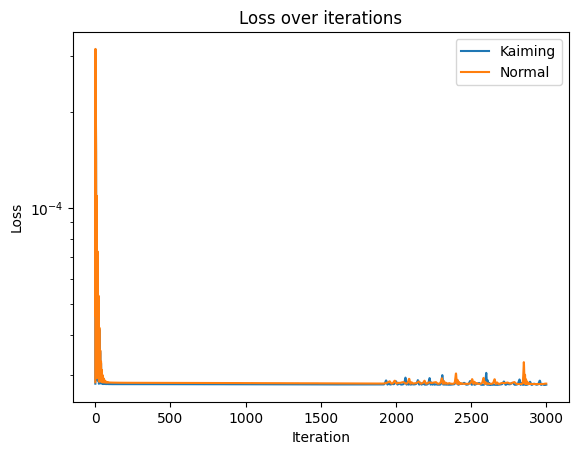

In [11]:

# It is probably easier to just implement one layer but have it take
# in a parameter that determines the initialization scheme


# creating two layers (one for each init scheme)
class Normalinit(Layer):
    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features)
        self.weight = np.random.normal(0,0.5,(in_features,out_features))
        self.bias = np.random.normal(0,0.5,out_features)

class KaimingInit(Layer):
    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features)
        self.weight = np.random.normal(0,np.sqrt(2/in_features),(in_features,out_features))
        self.bias = np.random.normal(0,np.sqrt(2/in_features),out_features)
        
l1 = Normalinit(1,32)
l2 = Normalinit(32,32)
l3 = Normalinit(32,1)
relu_1 = ReLU()
relu_2 = ReLU()
network = Network([layer1, relu_1, layer2, relu_2, layer3])
loss_fn = MeanSquaredLoss()
adam_optimizer = Adam(network, loss_fn, 0.001)
losses_normal= []
for i in range(3000):
    loss = adam_optimizer.update(x_data, y_data)
    losses_normal.append(loss.item())
    if i % 1000 == 0:
        print(f'Loss at iteration {i}: {loss}')

l1 = KaimingInit(1,32)
l2 = KaimingInit(32,32)
l3 = KaimingInit(32,1)
relu_1 = ReLU()
relu_2 = ReLU()
network = Network([layer1, relu_1, layer2, relu_2, layer3])
loss_fn = MeanSquaredLoss()
adam_optimizer = Adam(network, loss_fn, 0.001)
losses_kaiming= []
for i in range(3000):
    loss = adam_optimizer.update(x_data, y_data)
    losses_kaiming.append(loss.item())
    if i % 1000 == 0:
        print(f'Loss at iteration {i}: {loss}')

# Plot the losses on a log plot
plt.figure()
plt.plot(losses_kaiming, label='Kaiming')
plt.plot(losses_normal, label='Normal')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over iterations')

